1. CÀI ĐẶT THƯ VIỆN CẦN THIẾT

In [18]:
import sys
sys.modules["cupy"] = None


In [19]:
!pip install pyvi


In [20]:
import spacy
nlp = spacy.blank("vi")


In [21]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install openai

Note: you may need to restart the kernel to use updated packages.


In [23]:
import json
import spacy
import os

import numpy                            as np
import pandas                           as pd
import matplotlib.pyplot                as plt

from sklearn.feature_extraction.text    import CountVectorizer
from sklearn.decomposition              import LatentDirichletAllocation
from sklearn.metrics.pairwise           import cosine_distances
from collections                        import defaultdict
from sklearn.feature_extraction.text    import TfidfVectorizer
from sklearn.decomposition              import TruncatedSVD, NMF
from sklearn.metrics                    import silhouette_score
from gensim.corpora                     import Dictionary
from gensim.models.coherencemodel       import CoherenceModel
from spacy.lang.vi                      import Vietnamese
from openai                             import OpenAI

In [ ]:
pip install keybert easynmt

In [24]:
with open("/kaggle/input/dataset-final/data.json", "r", encoding="utf-8") as f:
    df = json.load(f)

df = pd.DataFrame(df)

texts = df["text_tfidf"].astype(str).tolist()

tokens = [t.split() for t in texts]
dictionary = Dictionary(tokens)

1. LDA

In [27]:
counts_vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=5,
    token_pattern=r"(?u)\b\w+\b"
)

X_counts = counts_vectorizer.fit_transform(texts)
feature_names = counts_vectorizer.get_feature_names_out()

print("BoW shape:", X_counts.shape)

BoW shape: (11226, 18754)


In [29]:
def get_model_top_words(model, feature_names, topn=10):
    return [
        [feature_names[i] for i in topic.argsort()[-topn:][::-1]]
        for topic in model.components_
    ]

In [30]:
def compute_compactness(doc_topic_dist):
    labels = doc_topic_dist.argmax(axis=1)
    compactness_values = []

    for topic in np.unique(labels):
        idx = np.where(labels == topic)[0]
        if len(idx) <= 1:
            continue

        vectors = doc_topic_dist[idx]
        centroid = vectors.mean(axis=0, keepdims=True)
        distances = cosine_distances(vectors, centroid)
        compactness_values.append(distances.mean())

    return np.mean(compactness_values)


def compute_separation(doc_topic_dist):
    labels = doc_topic_dist.argmax(axis=1)
    centroids = []

    for topic in np.unique(labels):
        idx = np.where(labels == topic)[0]
        if len(idx) == 0:
            continue

        centroids.append(doc_topic_dist[idx].mean(axis=0))

    centroids = np.array(centroids)

    if len(centroids) <= 1:
        return 0.0

    dist_matrix = cosine_distances(centroids)
    upper_triangle = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]

    return upper_triangle.mean()

In [31]:
k_list = range(5, 13)
feature_names = counts_vectorizer.get_feature_names_out()
results = []

for k in k_list:
    lda = LatentDirichletAllocation(
        n_components=k,
        random_state=42,
        learning_method="batch",
        max_iter=20,
        n_jobs=1
    )
    lda.fit(X_counts)

    doc_topic_dist = lda.transform(X_counts)

    comp = compute_compactness(doc_topic_dist)
    sep  = compute_separation(doc_topic_dist)
    score = sep / comp

    topics_words = get_model_top_words(lda, feature_names, topn=10)
    coh = CoherenceModel(
        topics=topics_words,
        texts=tokens,
        dictionary=dictionary,
        coherence="c_v"
    ).get_coherence()

    results.append({
        "K": k,
        "compactness": comp,
        "separation": sep,
        "score": score,
        "coherence": coh
    })

    print(f"K={k:02d} | Comp={comp:.4f} | Sep={sep:.4f} | Score={score:.4f} | Coh={coh:.4f}")

res_df = pd.DataFrame(results)
res_df

K=05 | Comp=0.0479 | Sep=0.8562 | Score=17.8724 | Coh=0.6162
K=06 | Comp=0.0510 | Sep=0.8737 | Score=17.1293 | Coh=0.6838
K=07 | Comp=0.0580 | Sep=0.8725 | Score=15.0521 | Coh=0.7054
K=08 | Comp=0.0644 | Sep=0.8714 | Score=13.5258 | Coh=0.7008
K=09 | Comp=0.0680 | Sep=0.8820 | Score=12.9785 | Coh=0.6811
K=10 | Comp=0.0694 | Sep=0.8883 | Score=12.7921 | Coh=0.6865
K=11 | Comp=0.0786 | Sep=0.8836 | Score=11.2385 | Coh=0.6857
K=12 | Comp=0.0839 | Sep=0.8831 | Score=10.5216 | Coh=0.6668


,K,compactness,separation,score,coherence
0,5,0.047906,0.856204,17.872412,0.616186
1,6,0.051007,0.873712,17.129306,0.683780
2,7,0.057966,0.872512,15.052084,0.705398
3,8,0.064426,0.871418,13.525826,0.700760
4,9,0.067958,0.881987,12.978509,0.681128
5,10,0.069444,0.888338,12.792136,0.686541
6,11,0.078626,0.883646,11.238541,0.685749
7,12,0.083929,0.883064,10.521558,0.666827


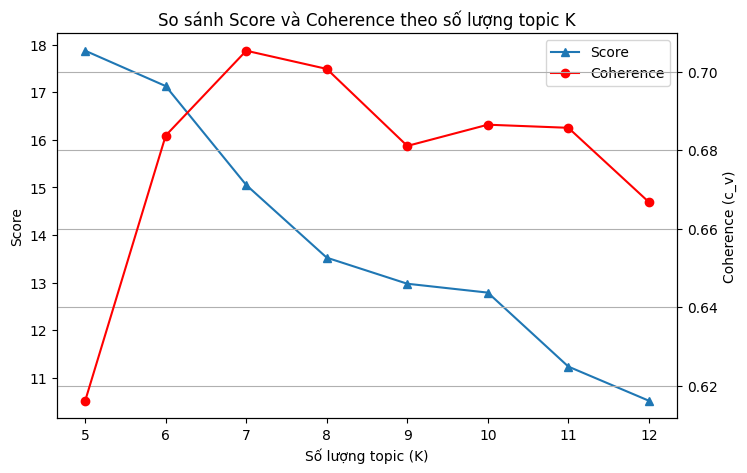

In [32]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(res_df["K"], res_df["score"], marker='^', label="Score")
ax1.set_xlabel("Số lượng topic (K)")
ax1.set_ylabel("Score")

ax2 = ax1.twinx()
ax2.plot(res_df["K"], res_df["coherence"], marker='o', label="Coherence", color ='red')
ax2.set_ylabel("Coherence (c_v)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("So sánh Score và Coherence theo số lượng topic K")
plt.grid(True)
plt.show()


In [33]:
lda_final = LatentDirichletAllocation(
    n_components=7,
    random_state=42,
    learning_method="batch",
    max_iter=20,
    n_jobs=1
)
lda_final.fit(X_counts)

LatentDirichletAllocation(max_iter=20, n_components=7, n_jobs=1,
                          random_state=42)

In [34]:
topics_words = get_model_top_words(lda_final, feature_names, topn=20)

for i, words in enumerate(topics_words):
    print(f"Topic {i}: {', '.join(words)}")

doc_topic_dist = lda_final.transform(X_counts)
dominant_topic = doc_topic_dist.argmax(axis=1)

Topic 0: đồng, tỷ, triệu, tiền, công_ty, giá, usd, hàng, công_an, vàng, thị_trường, vụ, mua, kinh_doanh, ngân_hàng, quy_định, tài_sản, thuế, điều_tra, bị_cáo
Topic 1: trận, việt_nam, đội, đấu, hai, bóng, giải, u, giành, thi_đấu, cầu_thủ, thắng, vòng, sân, bảng, nữ, hlv, ảnh, sea_games, chiến_thắng
Topic 2: tỉnh, ủy, chủ_tịch, phó, tổ_chức, ban, công_tác, trung_ương, địa_phương, cán_bộ, chính_trị, nhiệm_vụ, bí_thư, xã, đảng, quy_định, nhân_dân, ubnd, quốc_hội, chỉ_đạo
Topic 3: ảnh, đi, phim, hai, khán_giả, gia_đình, việt_nam, diễn_viên, đẹp, mẹ, sống, diễn, nghệ_sĩ, hình_ảnh, gái, hoa_hậu, trẻ, ca_sĩ, nghệ_thuật, nữ
Topic 4: việt_nam, phát_triển, kinh_tế, xây_dựng, hai, hợp_tác, doanh_nghiệp, quốc_tế, xã_hội, đầu_tư, quốc_gia, công_nghệ, chiến_lược, hiệu_quả, thủ_tướng, đổi_mới, dự_án, mục_tiêu, chính_sách, chính_phủ
Topic 5: bệnh_viện, bệnh, bác_sĩ, y_tế, bệnh_nhân, điều_trị, giúp, thuốc, khỏe, nguy_cơ, đường, sức, ung_thư, trẻ, máu, cơ_thể, sức_khỏe, uống, thực_phẩm, tim
Topic 6: trườ

In [35]:
def caption_compound_then_single(words, k=4):
    # words đã được sắp theo trọng số giảm dần từ LDA
    compounds = [w for w in words if "_" in w]
    singles   = [w for w in words if "_" not in w]

    ordered = compounds + singles
    return " ".join(w.replace("_", " ") for w in ordered[:k])
for i, words in enumerate(topics_words):
    print(f"Topic {i}: {caption_compound_then_single(words)}")

Topic 0: công ty công an thị trường kinh doanh
Topic 1: việt nam thi đấu cầu thủ sea games
Topic 2: chủ tịch tổ chức công tác trung ương
Topic 3: khán giả gia đình việt nam diễn viên
Topic 4: việt nam phát triển kinh tế xây dựng
Topic 5: bệnh viện bác sĩ y tế bệnh nhân
Topic 6: đại học giáo dục học sinh chương trình


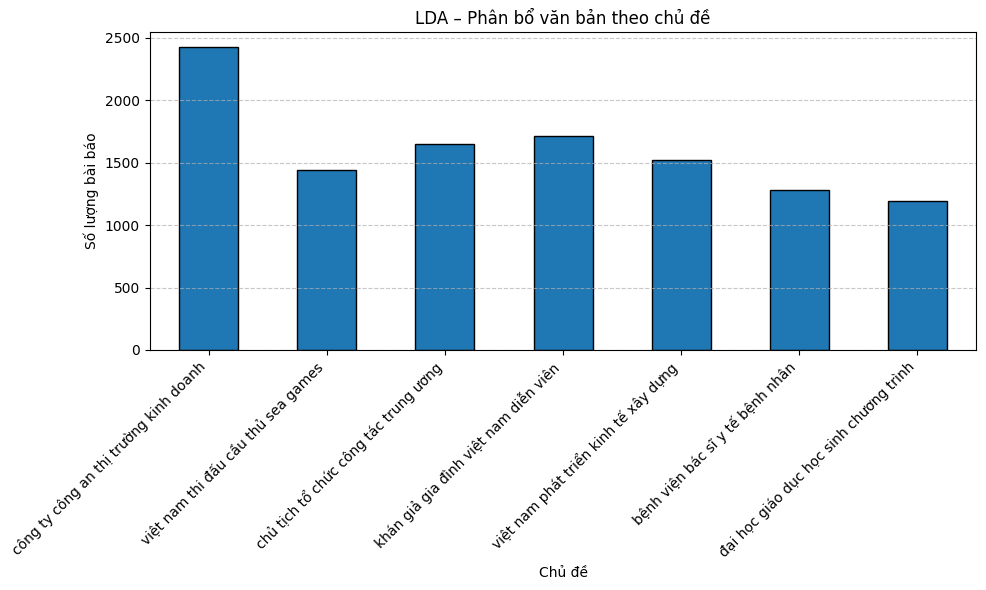

In [36]:
topic_captions = {
    i: caption_compound_then_single(words, k=4)
    for i, words in enumerate(topics_words)
}

topic_captions
doc_topic_dist = lda_final.transform(X_counts)
dominant_topic = doc_topic_dist.argmax(axis=1)

topic_counts = (
    pd.Series(dominant_topic)
    .value_counts()
    .sort_index()
)
plt.figure(figsize=(10, 6))

topic_counts.plot(
    kind="bar",
    edgecolor="black"
)

plt.title(f"LDA – Phân bổ văn bản theo chủ đề")
plt.xlabel("Chủ đề")
plt.ylabel("Số lượng bài báo")

plt.xticks(
    ticks=range(len(topic_counts)),
    labels=[topic_captions[i] for i in topic_counts.index],
    rotation=45,
    ha="right"
)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

2. NMF

In [169]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

X_tfidf = tfidf_vectorizer.fit_transform(df["text_ws"].astype(str))
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())


In [38]:
k_list = range(5, 13)
results_nmf = []

for k in k_list:
    nmf = NMF(
        n_components=k,
        random_state=42,
        init="nndsvd",
        max_iter=300
    )

    W = nmf.fit_transform(X_tfidf)   # doc–topic

    comp = compute_compactness(W)
    sep  = compute_separation(W)
    score = sep / comp

    topics_words = get_model_top_words(nmf, feature_names, topn=10)

    cm = CoherenceModel(
        topics=topics_words,
        texts=tokens,
        dictionary=dictionary,
        coherence="c_v"
    )
    coh = cm.get_coherence()

    results_nmf.append({
        "K": k,
        "compactness": comp,
        "separation": sep,
        "score": score,
        "coherence": coh
    })

    print(
        f"NMF | K={k:02d} | "
        f"Comp={comp:.4f} | Sep={sep:.4f} | "
        f"Score={score:.4f} | Coh={coh:.4f}"
    )

res_nmf_df = pd.DataFrame(results_nmf)
res_nmf_df

NMF | K=05 | Comp=0.0548 | Sep=0.8214 | Score=14.9995 | Coh=0.7286
NMF | K=06 | Comp=0.0589 | Sep=0.8426 | Score=14.3033 | Coh=0.7838
NMF | K=07 | Comp=0.0610 | Sep=0.8587 | Score=14.0663 | Coh=0.8039
NMF | K=08 | Comp=0.0656 | Sep=0.8644 | Score=13.1871 | Coh=0.7935
NMF | K=09 | Comp=0.0740 | Sep=0.8697 | Score=11.7525 | Coh=0.7964
NMF | K=10 | Comp=0.0759 | Sep=0.8769 | Score=11.5511 | Coh=0.7805
NMF | K=11 | Comp=0.0807 | Sep=0.8764 | Score=10.8620 | Coh=0.7808
NMF | K=12 | Comp=0.0817 | Sep=0.8844 | Score=10.8230 | Coh=0.7929


,K,compactness,separation,score,coherence
0,5,0.054760,0.821374,14.999464,0.728554
1,6,0.058907,0.842556,14.303267,0.783765
2,7,0.061043,0.858651,14.066299,0.803914
3,8,0.065551,0.864427,13.187064,0.793475
4,9,0.074003,0.869716,11.752522,0.796407
5,10,0.075917,0.876920,11.551075,0.780487
6,11,0.080688,0.876434,10.861963,0.780845
7,12,0.081710,0.884352,10.823013,0.792909


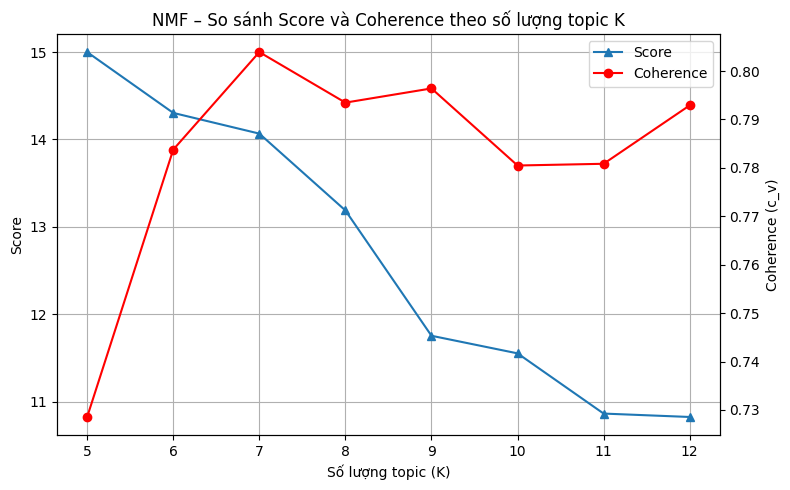

In [39]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(res_nmf_df["K"], res_nmf_df["score"], marker='^', label="Score")
ax1.set_xlabel("Số lượng topic (K)")
ax1.set_ylabel("Score")

ax2 = ax1.twinx()
ax2.plot(res_nmf_df["K"], res_nmf_df["coherence"], marker='o',
         label="Coherence", color='red')
ax2.set_ylabel("Coherence (c_v)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("NMF – So sánh Score và Coherence theo số lượng topic K")
ax1.grid(True)
plt.tight_layout()
plt.show()


In [41]:
nmf_final = NMF(
    n_components=7,
    random_state=42,
    init="nndsvd",
    max_iter=300
)

W = nmf_final.fit_transform(X_tfidf)

In [42]:
topics_words_nmf = get_model_top_words(nmf_final, feature_names, topn=20)
for i, words in enumerate(topics_words_nmf):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: việt_nam, phát_triển, thủ_tướng, hợp_tác, kinh_tế, xây_dựng, tổng_bí_thư, đảng, doanh_nghiệp, nhân_dân, chính_phủ, địa_phương, quốc_hội, công_nghệ, chính_trị, chiến_lược, đổi_mới, tổ_chức, đầu_tư, xã_hội
Topic 1: trận, đội, đấu, việt_nam, bóng, cầu_thủ, trận đấu, hlv, malaysia, thắng, giành, bảng, giải, sea_games, thi_đấu, bàn, vòng, chiến_thắng, sân, đội_tuyển
Topic 2: tỉnh, ủy, bí_thư, tỉnh ủy, phó, chủ_tịch, bí_thư tỉnh, ubnd, ban, chủ_tịch ubnd, phó bí_thư, chức, ubnd tỉnh, nhiệm_kỳ, chính_trị, đảng_bộ, trung_ương, đại_hội, thành ủy, hđnd
Topic 3: đồng, tỷ, tỷ đồng, triệu, công_ty, giá, vàng, triệu đồng, tiền, usd, cổ_phiếu, thị_trường, công_an, thuế, ngân_hàng, bị_cáo, giao_dịch, mua, giá vàng, tài_sản
Topic 4: bác_sĩ, bệnh_viện, bệnh_nhân, bệnh, điều_trị, y_tế, thuốc, ung_thư, máu, tim, thận, nguy_cơ, cấp_cứu, người_bệnh, gan, não, phẫu_thuật, khỏe, uống, ca
Topic 5: trường, đại_học, học_sinh, giáo_dục, sinh_viên, học, thi, đào_tạo, giáo_viên, trường đại_học, ngành, lớp,

In [43]:
topic_captions_nmf = {
    i: caption_compound_then_single(words)
    for i, words in enumerate(topics_words_nmf)
}

for i, cap in topic_captions_nmf.items():
    print(f"Topic {i}: {cap}")

Topic 0: việt nam phát triển thủ tướng hợp tác
Topic 1: việt nam cầu thủ sea games thi đấu
Topic 2: bí thư chủ tịch bí thư tỉnh chủ tịch ubnd
Topic 3: công ty cổ phiếu thị trường công an
Topic 4: bác sĩ bệnh viện bệnh nhân điều trị
Topic 5: đại học học sinh giáo dục sinh viên
Topic 6: diễn viên khán giả ca sĩ nghệ sĩ


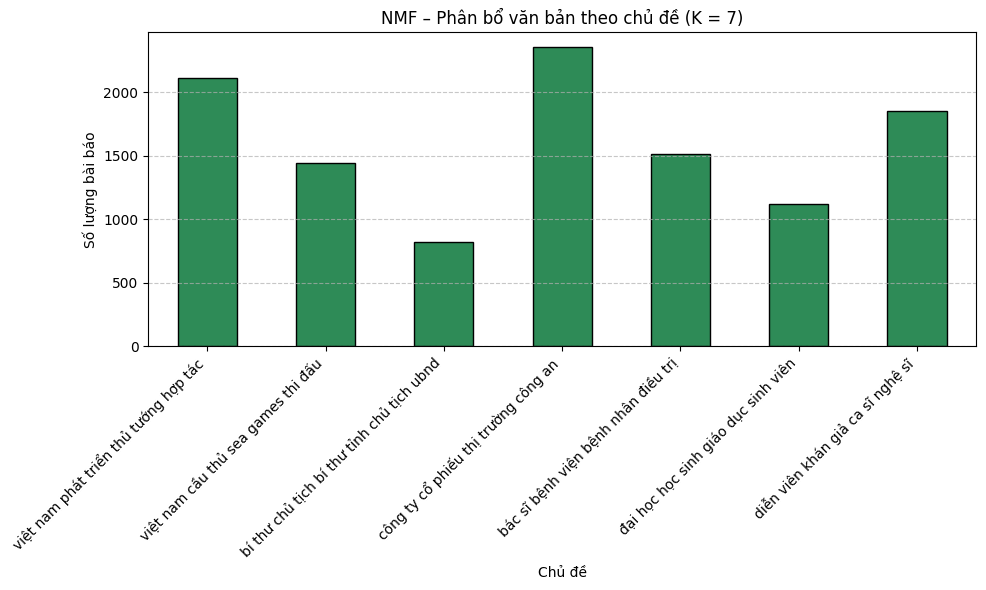

In [44]:
dominant_topic_nmf = W.argmax(axis=1)

topic_counts_nmf = (
    pd.Series(dominant_topic_nmf)
    .value_counts()
    .sort_index()
)
plt.figure(figsize=(10,6))

topic_counts_nmf.plot(
    kind="bar",
    edgecolor="black",
    color="seagreen"
)

plt.title("NMF – Phân bổ văn bản theo chủ đề (K = 7)")
plt.xlabel("Chủ đề")
plt.ylabel("Số lượng bài báo")

plt.xticks(
    ticks=range(len(topic_counts_nmf)),
    labels=[topic_captions_nmf[i] for i in topic_counts_nmf.index],
    rotation=45,
    ha="right"
)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

3. LSA

In [46]:
lsa_final = TruncatedSVD(
    n_components=7,
    random_state=42
)

X_lsa = lsa_final.fit_transform(X_tfidf)

In [48]:
k_list = range(5, 13)
results_lsa = []

for k in k_list:
    lsa = TruncatedSVD(n_components=k, random_state=42)
    X_lsa = lsa.fit_transform(X_tfidf)   # doc–topic

    comp = compute_compactness(X_lsa)
    sep  = compute_separation(X_lsa)
    score = sep / comp

    topics_words = [
        [feature_names[i] for i in compo.argsort()[-10:][::-1]]
        for compo in lsa.components_
    ]

    coh = CoherenceModel(
        topics=topics_words,
        texts=tokens,
        dictionary=dictionary,
        coherence="c_v"
    ).get_coherence()

    results_lsa.append({
        "K": k,
        "compactness": comp,
        "separation": sep,
        "score": score,
        "coherence": coh
    })

    print(f"LSA | K={k:02d} | Comp={comp:.4f} | Sep={sep:.4f} | Score={score:.4f} | Coh={coh:.4f}")

res_lsa_df = pd.DataFrame(results_lsa)

LSA | K=05 | Comp=0.0743 | Sep=0.7584 | Score=10.2096 | Coh=0.5912
LSA | K=06 | Comp=0.0769 | Sep=0.7768 | Score=10.1045 | Coh=0.6279
LSA | K=07 | Comp=0.0831 | Sep=0.7538 | Score=9.0677 | Coh=0.5726
LSA | K=08 | Comp=0.0895 | Sep=0.7895 | Score=8.8177 | Coh=0.5661
LSA | K=09 | Comp=0.0956 | Sep=0.8225 | Score=8.6073 | Coh=0.5471
LSA | K=10 | Comp=0.1040 | Sep=0.8175 | Score=7.8605 | Coh=0.5218
LSA | K=11 | Comp=0.1219 | Sep=0.8092 | Score=6.6388 | Coh=0.5279
LSA | K=12 | Comp=0.1259 | Sep=0.8121 | Score=6.4526 | Coh=0.5333


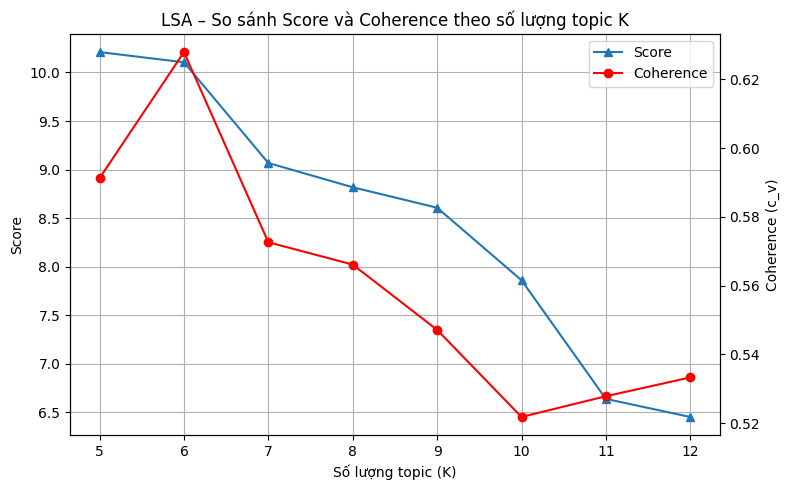

In [49]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(res_lsa_df["K"], res_lsa_df["score"], marker='^', label="Score")
ax1.set_xlabel("Số lượng topic (K)")
ax1.set_ylabel("Score")

ax2 = ax1.twinx()
ax2.plot(res_lsa_df["K"], res_lsa_df["coherence"], marker='o', label="Coherence", color='red')
ax2.set_ylabel("Coherence (c_v)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("LSA – So sánh Score và Coherence theo số lượng topic K")
ax1.grid(True)
plt.tight_layout()
plt.show()

In [50]:
best_k_lsa = 10

lsa_final = TruncatedSVD(
    n_components=best_k_lsa,
    random_state=42
)

X_lsa = lsa_final.fit_transform(X_tfidf)   # doc–topic

In [51]:
topics_words_lsa = [
    [feature_names[i] for i in compo.argsort()[-10:][::-1]]
    for compo in lsa_final.components_
]

for i, words in enumerate(topics_words_lsa):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: việt_nam, tỉnh, phát_triển, đồng, chủ_tịch, tổ_chức, thủ_tướng, hai, xây_dựng, ủy
Topic 1: tỉnh, ủy, bí_thư, chính_trị, tỉnh ủy, phó, trung_ương, đại_hội, chủ_tịch, đảng_bộ
Topic 2: trận, tỉnh, đội, đấu, ủy, bí_thư, việt_nam, bóng, cầu_thủ, trận đấu
Topic 3: tỉnh, đồng, bí_thư, ủy, tỷ đồng, tỷ, công_an, tiền, triệu đồng, triệu
Topic 4: bác_sĩ, bệnh_viện, bệnh_nhân, bệnh, điều_trị, trường, y_tế, thuốc, ung_thư, máu
Topic 5: trường, đại_học, thi, học_sinh, sinh_viên, giáo_dục, học, thí_sinh, giáo_viên, đào_tạo
Topic 6: trận, quy_định, trường, xã, công_chức, giáo_dục, địa_phương, luật, học_sinh, cán_bộ
Topic 7: giá, vàng, giá vàng, đại_học, usd, trường, thị_trường, bí_thư, cổ_phiếu, bác_sĩ
Topic 8: việt_nam, hợp_tác, tỉnh, chủ_tịch, quan_hệ, trường, bị_cáo, công_an, hai, đại_học
Topic 9: vàng, giá vàng, giá, công_an, triệu đồng, ounce, usd ounce, sjc, trường, học_sinh


In [53]:
best_k_lsa = 6

lsa_final = TruncatedSVD(
    n_components=best_k_lsa,
    random_state=42
)

X_lsa = lsa_final.fit_transform(X_tfidf)   # doc–topic

In [54]:
topics_words_lsa = [
    [feature_names[i] for i in compo.argsort()[-20:][::-1]]
    for compo in lsa_final.components_
]

for i, words in enumerate(topics_words_lsa):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: việt_nam, tỉnh, phát_triển, đồng, chủ_tịch, tổ_chức, thủ_tướng, hai, xây_dựng, ủy, kinh_tế, doanh_nghiệp, trường, chính_trị, phó, tỷ, địa_phương, trung_ương, triệu, ban
Topic 1: tỉnh, ủy, bí_thư, chính_trị, tỉnh ủy, phó, trung_ương, đại_hội, chủ_tịch, đảng_bộ, ubnd, bí_thư tỉnh, đảng, nhiệm_kỳ, ban, quốc_hội, cán_bộ, đại_biểu, chủ_tịch ubnd, phó bí_thư
Topic 2: trận, tỉnh, đội, đấu, ủy, bí_thư, việt_nam, bóng, cầu_thủ, trận đấu, hlv, tỉnh ủy, malaysia, đại_hội, sea_games, chủ_tịch, thắng, giành, ban, thi_đấu
Topic 3: tỉnh, đồng, bí_thư, ủy, tỷ đồng, tỷ, công_an, tiền, triệu đồng, triệu, tỉnh ủy, bị_cáo, vàng, giá, công_ty, bí_thư tỉnh, ubnd, điều_tra, phó, ubnd tỉnh
Topic 4: bác_sĩ, bệnh_viện, bệnh_nhân, bệnh, điều_trị, trường, y_tế, thuốc, ung_thư, máu, tim, thận, trẻ, cấp_cứu, tỉnh, học_sinh, nguy_cơ, đại_học, người_bệnh, ca
Topic 5: trường, đại_học, học_sinh, thi, giáo_dục, học, sinh_viên, thí_sinh, giáo_viên, đào_tạo, trường đại_học, thpt, tốt_nghiệp, lớp, phim, chương_trì

In [55]:
topic_captions_lsa = {
    i: caption_compound_then_single(words, k=4)
    for i, words in enumerate(topics_words_lsa)
}

for i, cap in topic_captions_lsa.items():
    print(f"Topic {i}: {cap}")

Topic 0: việt nam phát triển chủ tịch tổ chức
Topic 1: bí thư chính trị trung ương đại hội
Topic 2: bí thư việt nam cầu thủ đại hội
Topic 3: bí thư công an bị cáo công ty
Topic 4: bác sĩ bệnh viện bệnh nhân điều trị
Topic 5: đại học học sinh giáo dục sinh viên


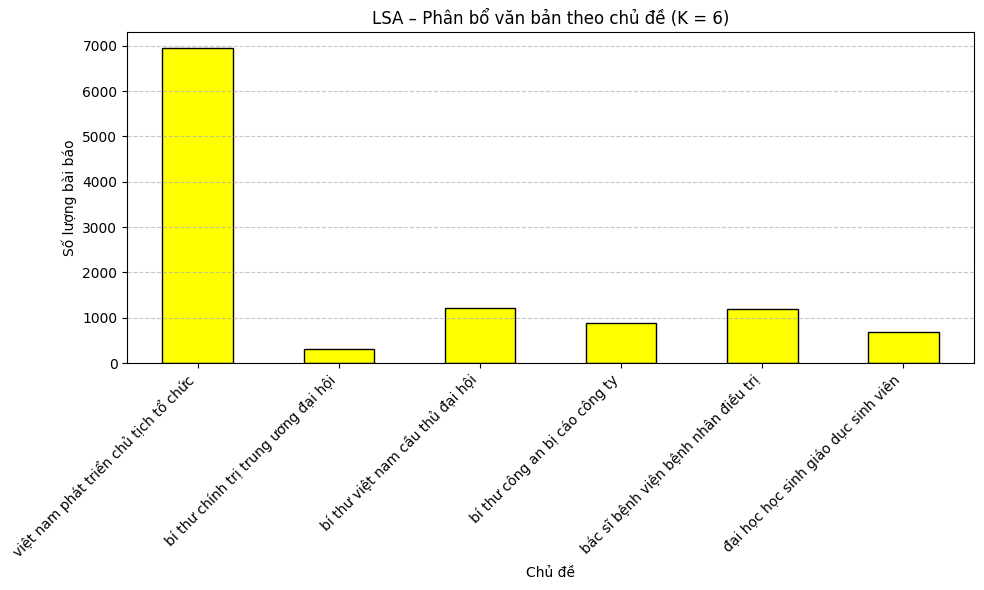

In [56]:
dominant_topic_lsa = X_lsa.argmax(axis=1)
topic_counts_lsa = (
    pd.Series(dominant_topic_lsa)
    .value_counts()
    .sort_index()
)
topic_counts_lsa

plt.figure(figsize=(10,6))

topic_counts_lsa.plot(
    kind="bar",
    edgecolor="black",
    color="yellow"
)

plt.title(f"LSA – Phân bổ văn bản theo chủ đề (K = {best_k_lsa})")
plt.xlabel("Chủ đề")
plt.ylabel("Số lượng bài báo")

plt.xticks(
    ticks=range(len(topic_counts_lsa)),
    labels=[topic_captions_lsa[i] for i in topic_counts_lsa.index],
    rotation=45,
    ha="right"
)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

THỬ NGHIỆM SINH CAPTION BẰNG TFIDF TRÊN THUẬT TOÁN KMEANS

In [124]:
from pyvi import ViTokenizer

def word_segment(text):
    if not isinstance(text, str):
        return ""
    return ViTokenizer.tokenize(text)


In [125]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# ===============================
# LOAD DATA
# ===============================
df = pd.read_json("/kaggle/input/dataset-final/data.json")

print("Columns:", df.columns)
print("Số văn bản:", len(df))

# ===============================
# TF-IDF VECTORIZE
# ===============================
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

X_tfidf = vectorizer.fit_transform(df["text"].astype(str))

print("TF-IDF shape:", X_tfidf.shape)

# ===============================
# KMEANS CLUSTERING
# ===============================
N_CLUSTERS = 8   # 🔥 chỉnh theo bài (vd: 8–12)

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init=10
)

df["cluster_kmeans"] = kmeans.fit_predict(X_tfidf)

print("✅ Đã gán nhãn cluster_kmeans")
print(df["cluster_kmeans"].value_counts())


Columns: Index(['category', 'url', 'title', 'content', 'publish_date', 'text',
       'text_embed', 'text_tfidf'],
      dtype='object')
Số văn bản: 11226
TF-IDF shape: (11226, 5000)
✅ Đã gán nhãn cluster_kmeans
cluster_kmeans
7    2449
4    1819
5    1409
1    1376
0    1275
3    1230
2    1011
6     657
Name: count, dtype: int64


In [89]:
df.to_json(
    "data_with_clusters.json",
    orient="records",
    force_ascii=False
)

print("✅ Đã lưu data_with_clusters.json")


✅ Đã lưu data_with_clusters.json


In [126]:
df["text_ws"] = df["text"].apply(word_segment)

In [74]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
import re


In [75]:
# 1. LOAD DỮ LIỆU TỪ KAGGLE INPUT
# =====================================================================
def load_data():
    """Load dữ liệu từ Kaggle input folder"""
    import os
    
    input_path = '/kaggle/input'
    json_file = None
    
    # Tự động tìm file JSON
    for root, dirs, files in os.walk(input_path):
        for file in files:
            if file.endswith('.json'):
                json_file = os.path.join(root, file)
                break
        if json_file:
            break
    
    if json_file is None:
        print("❌ Không tìm thấy file JSON trong /kaggle/input/")
        print("📌 Hãy upload dataset lên Kaggle trước!")
        return None
    
    print(f"📁 Đang đọc: {json_file}")
    
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.DataFrame(data)
    print(f"✅ Đã load {len(df)} bài báo")
    print(f"📊 Các cột: {df.columns.tolist()}")
    
    return df


In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

X_tfidf = vectorizer.fit_transform(df["text_ws"])
feature_names = np.array(vectorizer.get_feature_names_out())

In [157]:
def generate_caption_tfidf_from_matrix(
    X_tfidf,
    df,
    cluster_id,
    cluster_column="cluster_kmeans",
    top_n=10
):
    idx = df[df[cluster_column] == cluster_id].index.tolist()
    if len(idx) == 0:
        return []

    X_cluster = X_tfidf[idx]
    mean_tfidf = X_cluster.mean(axis=0).A1

    top_idx = mean_tfidf.argsort()[-top_n:][::-1]
    keywords = feature_names[top_idx]

    return keywords.tolist()


In [158]:
def generate_caption_frequency(cluster_texts, top_n=10):
    """
    Sinh caption dựa trên tần suất từ
    
    Args:
        cluster_texts: List các text trong cụm
        top_n: Số từ khóa trả về
    
    Returns:
        List từ khóa phổ biến
    """
    if not cluster_texts:
        return []
    
    # Gom text
    combined_text = ' '.join(cluster_texts).lower()
    
    # Tokenize đơn giản (tách theo space)
    words = combined_text.split()
    
    # Loại bỏ từ dừng tiếng Việt cơ bản
    stop_words = {
        'và', 'của', 'có', 'trong', 'được', 'cho', 'để', 'với', 'từ', 'này',
        'đã', 'là', 'một', 'các', 'những', 'sẽ', 'về', 'cũng', 'đang', 'khi',
        'như', 'không', 'bị', 'vào', 'ra', 'theo', 'đến', 'trên', 'sau', 'tại',
        'người', 'cả', 'hay', 'thì', 'nếu', 'bởi', 'nhiều', 'lại', 'làm', 'nên'
    }
    
    # Lọc từ dài hơn 2 ký tự và không phải stop word
    filtered_words = [w for w in words if len(w) > 2 and w not in stop_words]
    
    # Đếm tần suất
    word_freq = Counter(filtered_words)
    
    # Lấy top
    keywords = [word for word, count in word_freq.most_common(top_n)]
    
    return keywords


In [159]:
def refine_caption_final(keywords, top_n=10):
    if not keywords:
        return []

    seen = set()
    cleaned = []
    for kw in keywords:
        kw = kw.strip()
        if kw and kw not in seen:
            cleaned.append(kw)
            seen.add(kw)

    return cleaned[:top_n]


In [160]:
def make_topic_name(keywords):
    if not keywords:
        return ""

    return " – ".join(keywords[:3])


In [170]:
def generate_all_captions(
    df,
    cluster_column,
    method="tfidf",
    top_n=10,
    X_tfidf=None,
    feature_names=None,
    text_column="text"
):
    cluster_captions = {}

    for cluster_id in sorted(df[cluster_column].unique()):
        print(f"\n🔸 Cụm {cluster_id}")
        idx = df.index[df[cluster_column] == cluster_id].tolist()
        print(f"   📊 Số bài: {len(idx)}")

        # ====== TF-IDF (ĐÚNG CÁCH) ======
        if method == "tfidf":
            if X_tfidf is None or feature_names is None:
                raise ValueError("Thiếu X_tfidf/feature_names. Hãy tạo TF-IDF trên toàn dataset trước.")

            X_cluster = X_tfidf[idx]
            mean_tfidf = X_cluster.mean(axis=0).A1
            top_idx = mean_tfidf.argsort()[-top_n*2:][::-1]
            raw_keywords = feature_names[top_idx].tolist()

        # ====== Frequency (baseline) ======
        elif method == "frequency":
            cluster_texts = df.loc[idx, text_column].astype(str).tolist()
            raw_keywords = generate_caption_frequency(cluster_texts, top_n*2)

        else:
            raw_keywords = []

        refined = refine_caption_final(raw_keywords, top_n=top_n)
        topic_name = make_topic_name(refined)

        cluster_captions[cluster_id] = {"topic_name": topic_name, "keywords": refined}

        print(f"   🏷️  Topic name: {topic_name}")
        print(f"   🔑 Keywords: {', '.join(refined)}")

        # DEBUG nếu vẫn rỗng
        if len(refined) == 0:
            print("   ⚠️ DEBUG: refined rỗng. raw_keywords sample =", raw_keywords[:10])

    return cluster_captions


In [162]:
def add_captions_to_df(df, cluster_captions, cluster_column):

    df = df.copy()

    df["cluster_topic"] = df[cluster_column].map(
        lambda x: cluster_captions.get(x, {}).get("topic_name", "")
    )

    df["cluster_keywords"] = df[cluster_column].map(
        lambda x: ", ".join(
            cluster_captions.get(x, {}).get("keywords", [])
        )
    )

    return df


In [164]:
def save_captions(cluster_captions, out_file):
    rows = []

    for cid, info in cluster_captions.items():
        rows.append({
            "cluster_id": cid,
            "topic_name": info["topic_name"],
            "keywords": ", ".join(info["keywords"]),
            "top_3": ", ".join(info["keywords"][:3])
        })

    df = pd.DataFrame(rows)
    df.to_csv(out_file, index=False, encoding="utf-8-sig")
    return df


In [174]:
def visualize_captions(cluster_captions, output_file='caption_wordcloud.png'):
    """Vẽ word cloud cho từng cụm (PHÙ HỢP VỚI CẤU TRÚC MỚI)"""
    try:
        from wordcloud import WordCloud
        import matplotlib.pyplot as plt

        n_clusters = len(cluster_captions)
        cols = 3
        rows = (n_clusters + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
        axes = axes.flatten() if n_clusters > 1 else [axes]

        for idx, (cluster_id, data) in enumerate(sorted(cluster_captions.items())):
            if idx >= len(axes):
                break

            keywords = data.get("keywords", [])
            topic_name = data.get("topic_name", f"Cụm {cluster_id}")

            if not keywords:
                axes[idx].set_title(f"Cụm {cluster_id} (no keywords)")
                axes[idx].axis("off")
                continue

            # ===== Tạo text có trọng số (ưu tiên keyword đầu) =====
            weighted_text = []
            for i, kw in enumerate(keywords):
                weight = max(1, len(keywords) - i)
                weighted_text.extend([kw] * weight)

            text = " ".join(weighted_text)

            wordcloud = WordCloud(
                width=400,
                height=300,
                background_color="white",
                colormap="viridis",
                font_path=None  # thêm font nếu cần tiếng Việt
            ).generate(text)

            axes[idx].imshow(wordcloud, interpolation="bilinear")
            axes[idx].set_title(f"{topic_name}", fontsize=12, weight="bold")
            axes[idx].axis("off")

        # Ẩn subplot dư
        for i in range(idx + 1, len(axes)):
            axes[i].axis("off")

        plt.tight_layout()
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        plt.show()

        print(f"✅ Đã lưu word cloud: {output_file}")

    except ImportError:
        print("⚠️ Chưa cài wordcloud. Dùng: pip install wordcloud")
    except Exception as e:
        print(f"⚠️ Không thể tạo word cloud: {e}")


In [175]:
def process_cluster_captions(
    data_file,
    cluster_column='cluster',
    text_column='text',
    method='tfidf',
    top_n=10
):
    """
    Hàm chính để xử lý và sinh caption (HỖ TRỢ JSON / CSV)
    """

    print("=" * 70)
    print("🚀 SINH CAPTION CHO CLUSTERING RESULTS")
    print("=" * 70)

    # =========================
    # 1. LOAD DATA
    # =========================
    print(f"\n📁 Đang đọc: {data_file}")

    if data_file.endswith(".json"):
        df = pd.read_json(data_file)
    elif data_file.endswith(".csv"):
        df = pd.read_csv(data_file)
    else:
        raise ValueError("Chỉ hỗ trợ file .json hoặc .csv")

    print(f"✅ Đã load {len(df)} bài báo")
    print(f"📊 Số cụm: {df[cluster_column].nunique()}")

    # =========================
    # 2. TF-IDF (FIT 1 LẦN – RẤT QUAN TRỌNG)
    # =========================
    X_tfidf = None
    feature_names = None

    if method == "tfidf":
        print("🔧 Đang tạo TF-IDF cho toàn bộ dataset...")

        vectorizer = TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            min_df=5,
            max_df=0.9
        )

        X_tfidf = vectorizer.fit_transform(df[text_column].astype(str))
        feature_names = np.array(vectorizer.get_feature_names_out())

        print(f"✅ TF-IDF shape: {X_tfidf.shape}")

    # =========================
    # 3. SINH CAPTION (THEO CLUSTER)
    # =========================
    cluster_captions = generate_all_captions(
        df,
        cluster_column=cluster_column,
        text_column=text_column,
        method=method,
        top_n=top_n,
        X_tfidf=X_tfidf,
        feature_names=feature_names
    )

    # =========================
    # 4. SAVE CAPTIONS
    # =========================
    caption_df = save_captions(
        cluster_captions,
        f'cluster_captions_{method}.csv'
    )

    # =========================
    # 5. ADD TO DATAFRAME
    # =========================
    df_with_captions = add_captions_to_df(
        df,
        cluster_captions,
        cluster_column
    )

    output_data_file = f'clustered_with_captions_{method}.csv'
    df_with_captions.to_csv(
        output_data_file,
        index=False,
        encoding='utf-8-sig'
    )

    print(f"✅ Đã lưu: {output_data_file}")

    # =========================
    # 6. VISUALIZATION
    # =========================
    visualize_captions(
        cluster_captions,
        f'caption_wordcloud_{method}.png'
    )

    # =========================
    # 7. SUMMARY
    # =========================
    print("\n" + "=" * 70)
    print("📊 TỔNG KẾT CAPTIONS")
    print("=" * 70)
    print(caption_df.to_string(index=False))

    print("\n" + "=" * 70)
    print("🎉 HOÀN THÀNH!")
    print("=" * 70)

    return df_with_captions, cluster_captions



PHƯƠNG PHÁP 1: TF-IDF
🚀 SINH CAPTION CHO CLUSTERING RESULTS

📁 Đang đọc: data_with_clusters.json
✅ Đã load 11226 bài báo
📊 Số cụm: 8
🔧 Đang tạo TF-IDF cho toàn bộ dataset...
✅ TF-IDF shape: (11226, 5000)

🔸 Cụm 0
   📊 Số bài: 1275
   🏷️  Topic name: công an – an – bị
   🔑 Keywords: công an, an, bị, công, tra, điều tra, bị cáo, tội, án, người, cáo, phạm, tiền, vụ, đồng

🔸 Cụm 1
   📊 Số bài: 1376
   🏷️  Topic name: doanh – hàng – tăng
   🔑 Keywords: doanh, hàng, tăng, giá, sản, đồng, tỷ, thuế, thị trường, năm, công ty, ty, công, cổ, giảm

🔸 Cụm 2
   📊 Số bài: 1011
   🏷️  Topic name: học – giáo – sinh
   🔑 Keywords: học, giáo, sinh, trường, đại học, học sinh, giáo dục, dục, viên, sinh viên, đại, năm, khoa, thi, đào tạo

🔸 Cụm 3
   📊 Số bài: 1230
   🏷️  Topic name: bệnh – bác sĩ – viện
   🔑 Keywords: bệnh, bác sĩ, viện, bệnh viện, bác, bệnh nhân, ăn, sĩ, người, tim, thuốc, máu, điều trị, thể, cơ

🔸 Cụm 4
   📊 Số bài: 1819
   🏷️  Topic name: cô – tôi – anh
   🔑 Keywords: cô, tôi, anh, ngườ

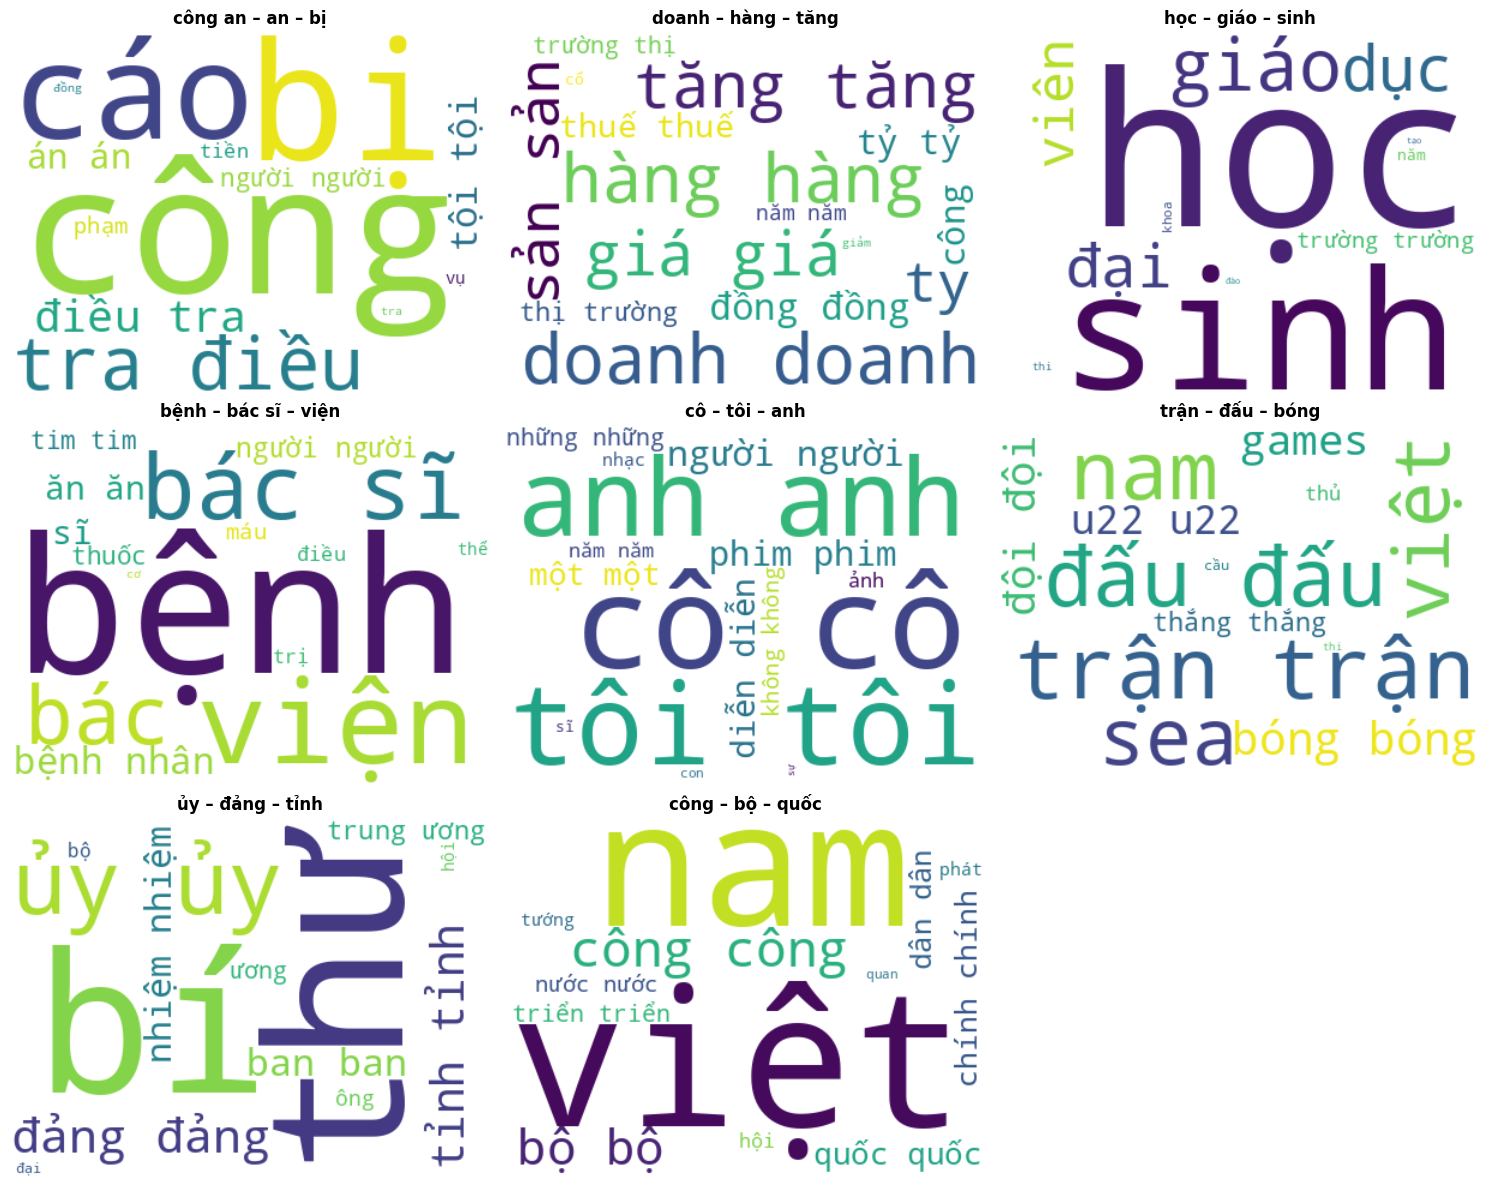

✅ Đã lưu word cloud: caption_wordcloud_tfidf.png

📊 TỔNG KẾT CAPTIONS
 cluster_id           topic_name                                                                                                 keywords              top_3
          0    công an – an – bị                  công an, an, bị, công, tra, điều tra, bị cáo, tội, án, người, cáo, phạm, tiền, vụ, đồng    công an, an, bị
          1  doanh – hàng – tăng                doanh, hàng, tăng, giá, sản, đồng, tỷ, thuế, thị trường, năm, công ty, ty, công, cổ, giảm  doanh, hàng, tăng
          2    học – giáo – sinh học, giáo, sinh, trường, đại học, học sinh, giáo dục, dục, viên, sinh viên, đại, năm, khoa, thi, đào tạo    học, giáo, sinh
          3 bệnh – bác sĩ – viện         bệnh, bác sĩ, viện, bệnh viện, bác, bệnh nhân, ăn, sĩ, người, tim, thuốc, máu, điều trị, thể, cơ bệnh, bác sĩ, viện
          4       cô – tôi – anh                          cô, tôi, anh, người, phim, diễn, một, những, không, năm, ảnh, nhạc, sĩ, con, sự       c

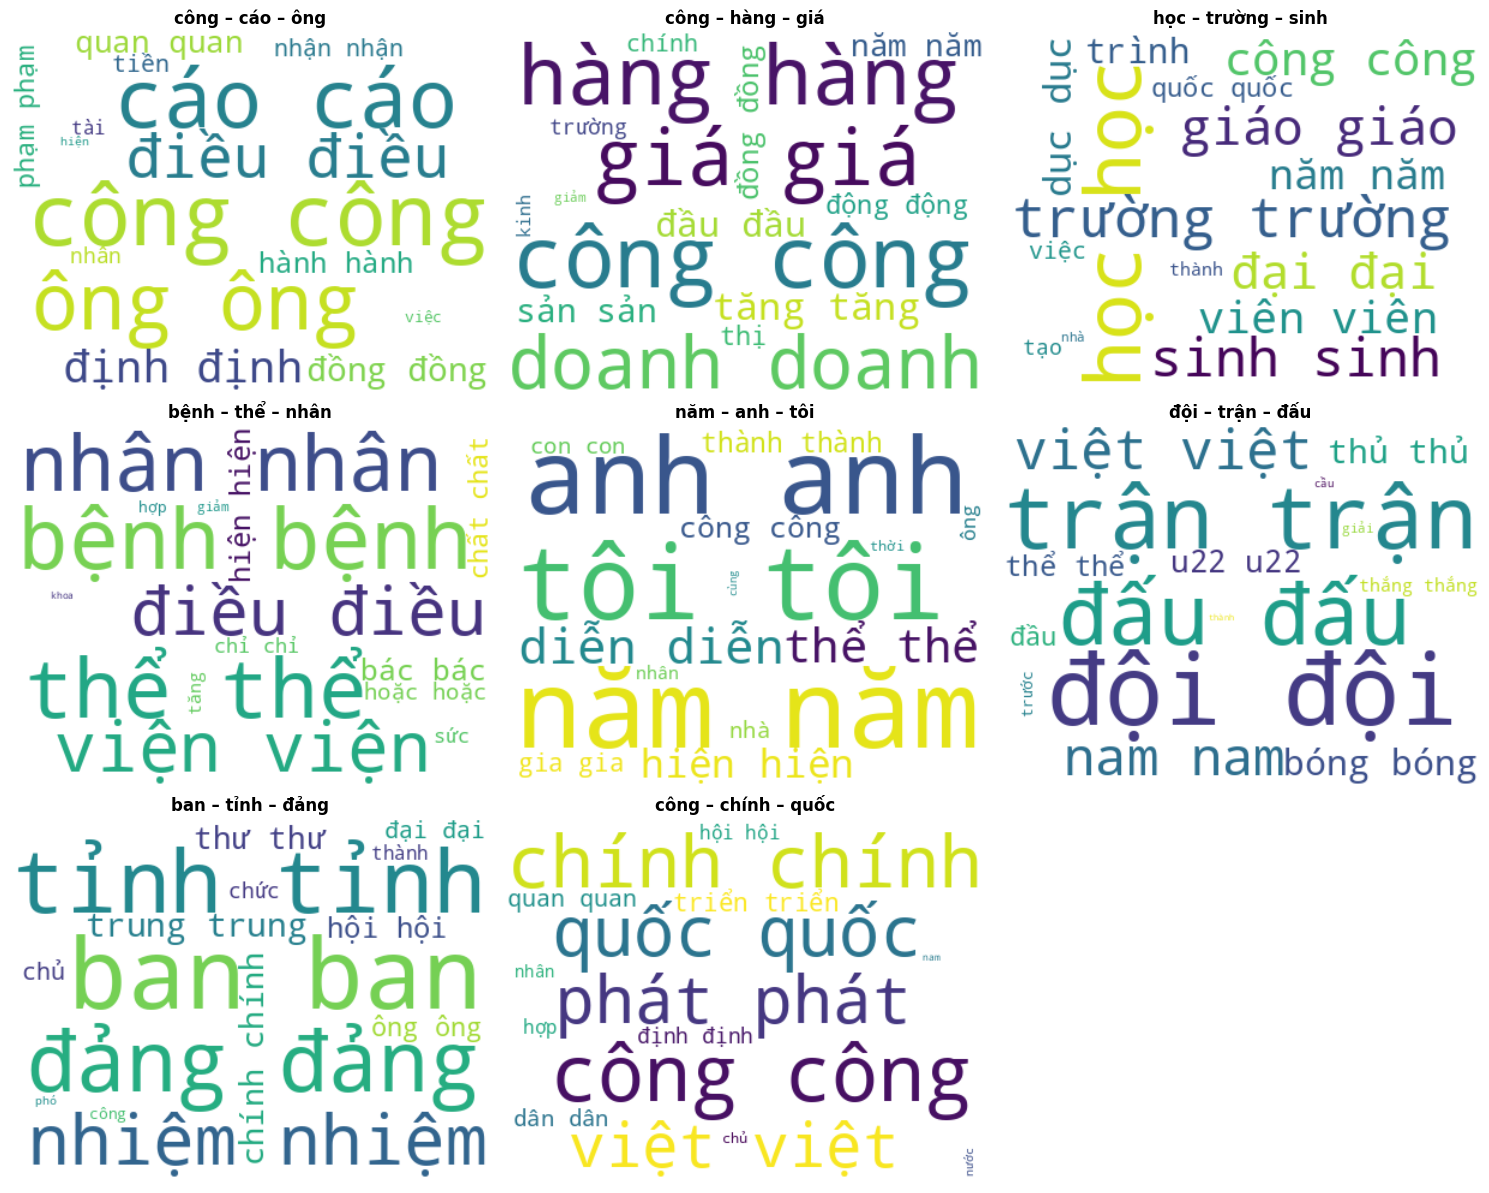

✅ Đã lưu word cloud: caption_wordcloud_frequency.png

📊 TỔNG KẾT CAPTIONS
 cluster_id          topic_name                                                                                keywords             top_3
          0    công – cáo – ông   công, cáo, ông, điều, định, đồng, quan, hành, phạm, nhận, tiền, nhân, tài, việc, hiện    công, cáo, ông
          1   công – hàng – giá công, hàng, giá, doanh, tăng, đầu, sản, năm, đồng, động, thị, chính, trường, kinh, giảm   công, hàng, giá
          2 học – trường – sinh  học, trường, sinh, giáo, đại, công, viên, năm, dục, quốc, trình, việc, tạo, thành, nhà học, trường, sinh
          3   bệnh – thể – nhân     bệnh, thể, nhân, viện, điều, bác, hiện, chất, hoặc, chỉ, sức, tăng, hợp, giảm, khoa   bệnh, thể, nhân
          4     năm – anh – tôi       năm, anh, tôi, diễn, thể, hiện, công, thành, gia, con, nhà, ông, nhân, thời, cùng     năm, anh, tôi
          5    đội – trận – đấu     đội, trận, đấu, việt, nam, bóng, thủ, u22, thể, thắng, đầu, tr

In [176]:
if __name__ == "__main__":

    DATA_FILE = "/kaggle/input/dataset-final/data.json"
    CLUSTER_COL = "cluster_kmeans"   # đổi nếu tên cột khác
    TEXT_COL = "text"

    # ==========================================================
    # PHƯƠNG PHÁP 1: TF-IDF (KHUYẾN NGHỊ)
    # ==========================================================
    print("\n" + "=" * 70)
    print("PHƯƠNG PHÁP 1: TF-IDF")
    print("=" * 70)
    
    df_tfidf, captions_tfidf = process_cluster_captions(
    data_file="data_with_clusters.json",
    cluster_column="cluster_kmeans",
    text_column="text",
    method="tfidf",
    top_n=15
)

    # ==========================================================
    # PHƯƠNG PHÁP 2: FREQUENCY (BACKUP)
    # ==========================================================
    print("\n" + "=" * 70)
    print("PHƯƠNG PHÁP 2: FREQUENCY")
    print("=" * 70)

    df_freq, captions_freq = process_cluster_captions(
    data_file="data_with_clusters.json",
    cluster_column="cluster_kmeans",
    text_column="text",
    method="frequency",
    top_n=15
)
